In [1]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
import tensorflow as tf
import tensorflow.keras as keras
import tensorflowjs as tfjs
import numpy as np
from PIL import Image
import time
import sys
import cProfile, pstats
import scipy.ndimage as nd
import functools
import importlib
from IPython.display import display,clear_output
stime = time.time()

In [11]:
model = keras.applications.resnet.ResNet50(
      include_top=True, weights='imagenet', classes=1000,
      classifier_activation='softmax')
shp = (1,)+model.input.shape[1:]
print(shp)


(1, 224, 224, 3)


In [12]:
def printstats(deffted):
    print("imgmax", tf.math.reduce_max(deffted))
    print("imgmin", tf.math.reduce_min(deffted))
    print("imgsum",tf.reduce_sum(deffted))

In [39]:
def rfft2d_freqs(h, w):
    """Computes 2D spectrum frequencies."""

    fy = np.fft.fftfreq(h)[:, None]
    # when we have an odd input dimension we need to keep one additional
    # frequency and later cut off 1 pixel
    if w % 2 == 1:
        fx = np.fft.fftfreq(w)[: w // 2 + 2]
    else:
        fx = np.fft.fftfreq(w)[: w // 2 + 1]
    return np.sqrt(fx * fx + fy * fy)


def fft_init(shape, sd=None, decay_power=1):
    """An image paramaterization using 2D Fourier coefficients."""

    sd = sd or 0.01
    batch, h, w, ch = shape
    freqs = rfft2d_freqs(h, w)
    init_val_size = (2, batch, ch) + freqs.shape

    init_val = np.random.normal(size=init_val_size, scale=sd).astype(np.float32)
    spectrum_real_imag_t = tf.Variable(init_val)

    spectrum_t = tf.complex(spectrum_real_imag_t[0], spectrum_real_imag_t[1])

    # Scale the spectrum. First normalize energy, then scale by the square-root
    # of the number of pixels to get a unitary transformation.
    # This allows to use similar leanring rates to pixel-wise optimisation.
    scale = 1.0 / np.maximum(freqs, 1.0 / max(w, h)) ** decay_power
    scale *= np.sqrt(w * h)
    scaled_spectrum_t = scale * spectrum_t
    spectrum_reals = tf.stack([tf.math.real(scaled_spectrum_t), tf.math.imag(scaled_spectrum_t)], 0)
    # print(spectrum_reals)
    return spectrum_reals
    # convert complex scaled spectrum to shape (h, w, ch) image tensor
    # needs to transpose because irfft2d returns channels first
      
def fft_image(params):
    image_t = tf.transpose(tf.signal.irfft2d(tf.complex(params[0],params[1])), (0, 2, 3, 1))
#     printstats(image_t)
    image_t = tf.image.yuv_to_rgb(tf.concat([tf.clip_by_value(image_t[:,:,:,0:1]*0.5+0.5,0,1),
                                                              tf.clip_by_value(image_t[:,:,:,1:]*0.5,-0.5,0.5)],3))*2-1
    # in case of odd spatial input dimensions we need to crop
    image_t = image_t * 64   # TODO: is that a magic constant?
#     image_t = image_t*128+128
#     image_t = imag
#     image_t = tf.clip_by_value(image_t, 0,255)
    return image_t
def defft_image(image):
    scaled_spectrum_t = tf.signal.rfft2d(tf.transpose(image, (0,3,1,2)))
    reals = tf.stack([tf.math.real(scaled_spectrum_t), tf.math.imag(scaled_spectrum_t)], 0)
    return reals

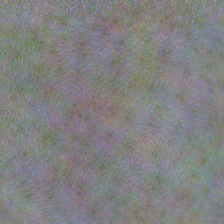

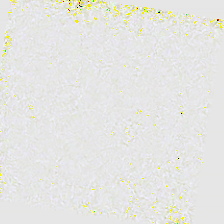

imgmax tf.Tensor(104.42093, shape=(), dtype=float32)
imgmin tf.Tensor(-89.356895, shape=(), dtype=float32)
imgsum tf.Tensor(128028.32, shape=(), dtype=float32)
imgmax tf.Tensor(107.215744, shape=(), dtype=float32)
imgmin tf.Tensor(-89.49334, shape=(), dtype=float32)
imgsum tf.Tensor(128041.96, shape=(), dtype=float32)
imgmax tf.Tensor(109.430725, shape=(), dtype=float32)
imgmin tf.Tensor(-93.28566, shape=(), dtype=float32)
imgsum tf.Tensor(128359.99, shape=(), dtype=float32)
imgmax tf.Tensor(112.64011, shape=(), dtype=float32)
imgmin tf.Tensor(-93.18005, shape=(), dtype=float32)
imgsum tf.Tensor(128502.09, shape=(), dtype=float32)
imgmax tf.Tensor(113.98123, shape=(), dtype=float32)
imgmin tf.Tensor(-91.84721, shape=(), dtype=float32)
imgsum tf.Tensor(129340.92, shape=(), dtype=float32)
imgmax tf.Tensor(113.98859, shape=(), dtype=float32)
imgmin tf.Tensor(-90.67673, shape=(), dtype=float32)
imgsum tf.Tensor(129836.43, shape=(), dtype=float32)
imgmax tf.Tensor(114.22778, shape=(), dtype

In [ ]:
import transforms
importlib.reload(transforms)

show_crop = 6

fromback=True
limitmag=False
one_batch=True
jitter =False
tjitternum = 4
total_variation =False
fixed_steps =True
blur =False
single = False
animate=True
skipdone = False
use_transform = True
use_decay = True
steps = 256


lossdiffthreshold = 0.1
sval = 0.0 # only works if power of 2?
sval = 0.0 # only works if power of 2?
transform = transforms.compose([    
    transforms.pad(12, mode="constant", constant_value=0),
    transforms.jitter(8),
    transforms.random_scale([1 + (i - 5) / 50.0 for i in range(0,11)]),
    transforms.random_rotate(list(range(-10, 11)) + 5 * [0]),
    transforms.jitter(4),
    transforms.unpad(12)
   ])

# transform = transforms.compose([    
#     transforms.pad(12, mode="constant", constant_value=0),
#     transforms.jitter(4),
#     transforms.random_scale([1 + (i - 3) / 50.0 for i in range(7)]),
#     transforms.random_rotate(list(range(-6, 7)) + 3 * [0]),
#     transforms.jitter(2),
#     transforms.unpad(12)
#    ])

class Adam:
      def __init__(self, params, lr):
            self.lr = lr
            self.z = 1
      def step(self, params):
            return params
adam = tf.keras.optimizers.Adam(learning_rate=0.1)
def tou8_range(tensor):
    mx = tf.math.reduce_max(tensor)
    mn = tf.math.reduce_min(tensor)
    return ((tensor/(mx-mn)+mn)*255).numpy().astype(np.uint8)
def tou8(tensor):
    return (tensor+128).numpy().astype(np.uint8)
def optneuron(model, layer, idx, num, single):
    new_model = tf.keras.Model(inputs=model.inputs, outputs=[layer.output])
    step_size = 1
    momentum = 0.01
    # img = tf.fill((num,)+shp[1:], sval)
    imgshape = (num,)+shp[1:]
    img= fft_init(imgshape)
    momentum_vector = tf.fill(img.shape, 0.0)
    best_loss = -9999999999900.9
    best_loss_step = 0
    now_ldthresh = lossdiffthreshold
    regularization_amount = 11.0
    # gaussian_kernel = _gaussian_kernel(10,regularization_amount, 3)
    decays = 0
    for step in range(steps):
        with tf.GradientTape() as tape:
            tape.watch(img)
            deffted = fft_image(img)
            img_pure = deffted
            printstats(img_pure)
            if use_transform:
                deffted = transform(deffted)

#             Image.fromarray(deffted.numpy()[0].astype(np.uint8)).show()
            activation = new_model(deffted)
            lst = []
            for j in range(num):
                begin = None
                size = None
                if len(activation.shape)==4:
                    begin = [j,activation.shape[1]//2,activation.shape[2]//2,idx+j] if single else [j,0,0,idx+j]
                    size = [1,1,1,1] if single else [1,-1,-1,1]
                elif len(activation.shape)==2:
                    begin = [j,idx+j] if single else [j,idx+j]
                    size = [1,1] if single else [1,1]
                else:
                    print("weird act shape", activation.shape)
                lst.append(tf.slice(activation, begin=begin, size=size))
            loss = tf.math.reduce_sum(tf.math.add_n(lst))
            if total_variation:
                tv = tf.reduce_mean(tf.image.total_variation(img))
                loss-=tv*10000
            if limitmag:
                absloss =tf.math.reduce_mean(tf.math.abs(img_pure))*10
                print("absloss", absloss)
                loss-=absloss
                magloss = tf.math.reduce_mean(img_pure*img_pure)
                print("magloss",magloss)
#             print("loss",loss)
            gradient = tape.gradient(loss, img)
            sm = tf.reduce_sum(gradient)
#             print("gradnorm", tf.norm(gradient))
            gradient /= tf.math.reduce_std(gradient) + 1e-8
            momentum_vector = momentum*momentum_vector+step_size*gradient
#             img = tf.clip_by_value(defft_image(img_purel;l;l;l;l;l;l;;;l;l;l;l;l;l;l;l;l;l;l;l;l;l,-130000,130000)
            img += momentum_vector
            #          adam.minimize(-loss,[img], tape=tape)
            if animate and step%30==0:
                pimg = Image.fromarray(tou8(img_pure[0]))
                clear_output()
                display(pimg)
                gimg = Image.fromarray(tou8_range(fft_image(gradient)[0]))
                display(gimg)
#                 print(gradient)
            if blur:
                img = img.numpy()
                img = nd.filters.gaussian_filter(img, [0,regularization_amount,regularization_amount,0], order=0)
                img = tf.convert_to_tensor(img)
            if blur and step>0 and step%10==0:
               # regularization_amount*=0.5
               gaussian_kernel = _gaussian_kernel(5, regularization_amount,3)
            if loss>best_loss+now_ldthresh:
                best_loss = loss
                best_loss_step = step
            
            elif not fixed_steps and step-best_loss_step>=20:
                decays +=1
                print("decaying at", step)
                step_size *-0.2
                if decays>2:
                    print("stopped early after", step, "steps")
                    break
    return fft_image(img)

def cropsval(batch):
   left = 0
   for i in range(shp[1]):
      if batch[0,i,batch.shape[2]//2, 0]!=sval:
         left = i
         break
   right = 0
   for i in range(shp[1]-1, -1,-1):
      if batch[0,i,batch.shape[2]//2, 0]!=sval:
         right = i
         break
   top = 0
   for i in range(shp[1]):
      if batch[0,batch.shape[2]//2,i, 0]!=sval:
         top = i
         break
   bottom = 0
   for i in range(shp[1]-1, -1,-1):
      if batch[0,batch.shape[2]//2,i, 0]!=sval:
         bottom = i
         break
   cropped = tf.slice(batch, [0, top, left, 0], [-1, bottom-top, right-left, -1])
   return cropped
   
      
spath = "./deepdream"
if not os.path.exists(spath):
   os.mkdir(spath)
spath+= "/single" if single else "/filter"
if not os.path.exists(spath):
   os.mkdir(spath)
   
mpath =spath+ '/'+'ResNet50'
if not os.path.exists(mpath):
   os.mkdir(mpath)

max_batch = 16 if one_batch else 96


def __main__():
   print(mpath)
   layers = reversed(list(model.layers)) if fromback else list(model.layers)
   for layer in layers:
      oldcrit = (layer.weights and layer.trainable and   layer.name[-2:]!='bn'and layer.name[:5]!='batch')
      addcrit = (layer.name[-3:] in ['add']) 
      if oldcrit:
         lpath = mpath+"/"+layer.name
         if not os.path.exists(lpath):
            os.mkdir(lpath)
         elif skipdone:
            continue
         nfilters = layer.output.shape[-1]
         for start in range(0,nfilters, max_batch):
            num = min(nfilters, start+max_batch)-start
            img = optneuron(model, layer, start, num, single)
#             cropped = cropsval(img)
            cropped = tf.slice(img, [0,show_crop, show_crop, 0],[-1,img.shape[1]-show_crop*2, img.shape[2]-show_crop*2, -1])
            if cropped.shape[1]==0: 
               print("cropped size zero!")
               continue
            npy = tou8(cropped)
            for j in range(num):
               pilimg = Image.fromarray(npy[j])
               # pilimg.show()
               fname = lpath+"/"+str(j+start)+".png"
               if j==0: display(pilimg)
               try: # try catch so it doesn't fail if you had that image open in windows
                  pilimg.save(fname)
               except:
                  print("couldn't write", fname)
                  pass
               # with open(fname, 'wb') as f:
            #    f.write(img.numpy().tobytes())   
            print(layer.name+"/"+str(start+num))
            if one_batch: break
__main__()